# Initialize a game

In [1]:
from ConnectN import ConnectN

game_setting = {'size':(6,6), 'N':4, 'pie_rule':True}
game = ConnectN(**game_setting)


<IPython.core.display.Javascript object>


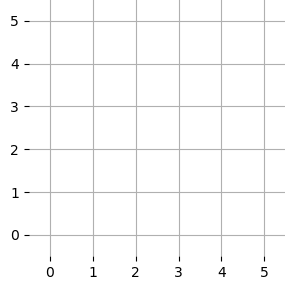

In [3]:
%matplotlib notebook

from Play import Play


gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=None)


# Define our policy

Please go ahead and define your own policy! See if you can train it under 1000 games and with only 1000 steps of exploration in each move.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import *
import numpy as np

from ConnectN import ConnectN
game_setting = {'size':(6,6), 'N':4}
game = ConnectN(**game_setting)

class Policy(nn.Module):

    def __init__(self, game):
        super(Policy, self).__init__()

        # input = 6x6 board
        # convert to 5x5x8
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2, stride=1, bias=False)
        # 5x5x16 to 3x3x32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, bias=False)

        self.size=3*3*32
        
        # the part for actions
        self.fc_action1 = nn.Linear(self.size, self.size//4)
        self.fc_action2 = nn.Linear(self.size//4, 36)
        
        # the part for the value function
        self.fc_value1 = nn.Linear(self.size, self.size//6)
        self.fc_value2 = nn.Linear(self.size//6, 1)
        self.tanh_value = nn.Tanh()
        
    def forward(self, x):

        y = F.leaky_relu(self.conv1(x))
        y = F.leaky_relu(self.conv2(y))
        y = y.view(-1, self.size)
        
        # action head
        a = self.fc_action2(F.leaky_relu(self.fc_action1(y)))
        
        avail = (torch.abs(x.squeeze())!=1).type(torch.FloatTensor)
        avail = avail.reshape(-1, 36)
        maxa = torch.max(a)
        exp = avail*torch.exp(a-maxa)
        #avail is a mask 
        prob = exp/torch.sum(exp)
        
        # value head
        value = self.tanh_value(self.fc_value2(F.leaky_relu( self.fc_value1(y) )))
        return prob.view(6,6), value

policy = Policy(game)


# Define a MCTS player for Play

In [6]:
import MCTS

from copy import copy

def Policy_Player_MCTS(game):
    mytree = MCTS.Node(copy(game))
    for _ in range(1000):
        mytree.explore(policy)
       
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
    
    return mytreenext.game.last_move

import random

def Random_Player(game):
    return random.choice(game.available_moves())    


# Play a game against a random policy

<IPython.core.display.Javascript object>


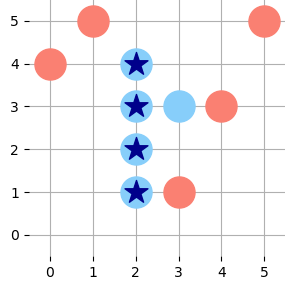

/home/yhong/Udacity-Deep-Reinforcement-Learning-Nanodegree/alphazero-tictactoe/MCTS.py:68: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  return game.available_moves(), tinv(prob)[mask].view(-1), v.squeeze().squeeze()


In [7]:
%matplotlib notebook

from Play import Play


gameplay=Play(ConnectN(**game_setting), 
              player1=Policy_Player_MCTS, 
              player2=None)


# Training

In [8]:
# initialize our alphazero agent and optimizer
import torch.optim as optim

game=ConnectN(**game_setting)
policy = Policy(game)
optimizer = optim.Adam(policy.parameters(), lr=.01, weight_decay=1.e-5)


Beware, training is **VERY VERY** slow!!

In [9]:
# train our agent

from collections import deque
import MCTS

# try a higher number
episodes = 2000

import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()

outcomes = []
policy_loss = []

Nmax = 1000

for e in range(episodes):

    mytree = MCTS.Node(game)
    #doesn't this reset the node? Yes it does. (THEME:REUSE can we reuse existing tree?)
    logterm = []
    vterm = []
    
    while mytree.outcome is None:
        for _ in range(Nmax):
            mytree.explore(policy)
            if mytree.N >= Nmax:
                break
            
        current_player = mytree.game.player
        mytree, (v, nn_v, p, nn_p) = mytree.next()
        mytree.detach_mother()# this will prevent backprop affecting higher up than current
        # this style of training focuses the training on the later nodes
        
        loglist = torch.log(nn_p)*p
        constant = torch.where(p>0, p*torch.log(p),torch.tensor(0.))
        logterm.append(-torch.sum(loglist-constant)) # I dont understand this part, where is the norm?

        vterm.append(nn_v*current_player) #here we are converting the nn_v in terms of the root nn_v
        
    # we compute the "policy_loss" for computing gradient
    outcome = mytree.outcome
    outcomes.append(outcome)
    
    loss = torch.sum( (torch.stack(vterm)-outcome)**2 + torch.stack(logterm) )
    optimizer.zero_grad()
    loss.backward()
    policy_loss.append(float(loss))

    optimizer.step()
    
    if e%100==0:
        print("game: ",e+1, ", mean loss: {:3.2f}".format(np.mean(policy_loss[-20:])),
              ", recent outcomes: ", outcomes[-10:])
    
    if e%500==0:
        torch.save(policy,'6-6-4-pie-{:d}.mypolicy'.format(e))
    del loss
    
    timer.update(e+1)
    
timer.finish()





training loop:   0% |                                          | ETA:  --:--:--/home/yhong/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:147: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  Variable._execution_engine.run_backward(
training loop:   0% |                                   | ETA:  2 days, 2:14:36

game:  1 , mean loss: 21.92 , recent outcomes:  [-1]


training loop:   5% |##                                        | ETA:   9:40:29

game:  101 , mean loss: 5.32 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  10% |####                                      | ETA:   7:04:09

game:  201 , mean loss: 2.38 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  15% |######                                    | ETA:   6:01:46

game:  301 , mean loss: 5.44 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  20% |########                                  | ETA:   5:41:41

game:  401 , mean loss: 1.47 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  25% |##########                                | ETA:   5:02:16

game:  501 , mean loss: 0.57 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  30% |############                              | ETA:   4:24:03

game:  601 , mean loss: 0.42 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  35% |##############                            | ETA:   3:52:50

game:  701 , mean loss: 0.34 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  40% |################                          | ETA:   3:25:47

game:  801 , mean loss: 0.21 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  45% |##################                        | ETA:   3:00:07

game:  901 , mean loss: 0.31 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  50% |#####################                     | ETA:   2:40:34

game:  1001 , mean loss: 1.33 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  55% |#######################                   | ETA:   2:23:57

game:  1101 , mean loss: 5.40 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  60% |#########################                 | ETA:   2:08:21

game:  1201 , mean loss: 0.55 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  65% |###########################               | ETA:   1:50:24

game:  1301 , mean loss: 0.17 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  70% |#############################             | ETA:   1:32:46

game:  1401 , mean loss: 0.14 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  75% |###############################           | ETA:   1:16:27

game:  1501 , mean loss: 1.00 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  80% |#################################         | ETA:   1:00:22

game:  1601 , mean loss: 1.35 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  85% |###################################       | ETA:   0:45:15

game:  1701 , mean loss: 2.76 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  90% |#####################################     | ETA:   0:30:17

game:  1801 , mean loss: 1.42 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop:  95% |#######################################   | ETA:   0:15:09

game:  1901 , mean loss: 2.68 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop: 100% |##########################################| Time:  5:05:39


# setup environment to pit your AI against the challenge policy '6-6-4-pie.policy'

In [22]:
challenge_policy = torch.load('6-6-4-pie.policy')

def Challenge_Player_MCTS(game):
    mytree = MCTS.Node(copy(game))
    for _ in range(1000):
        mytree.explore(challenge_policy)
       
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
    
    return mytreenext.game.last_move



# Let the game begin!

<IPython.core.display.Javascript object>


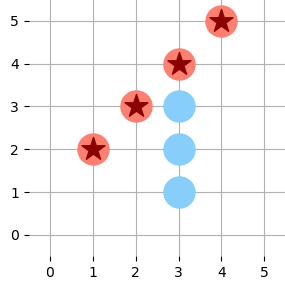

In [12]:
%matplotlib notebook
gameplay=Play(ConnectN(**game_setting), 
              player2=Policy_Player_MCTS, 
              player1=Challenge_Player_MCTS)

In [32]:
challenge_policy2 = torch.load('6-6-4-pie-1500.github')

def Challenge_Player_MCTS2(game):
    mytree = MCTS.Node(copy(game))
    for _ in range(1000):
        mytree.explore(challenge_policy2)
       
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
    
    return mytreenext.game.last_move


In [43]:
challenge_policy3 = torch.load('6-6-4-pie-1500.mypolicy')

def Challenge_Player_MCTS3(game):
    mytree = MCTS.Node(copy(game))
    for _ in range(2000):
        mytree.explore(challenge_policy3)
       
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
    
    return mytreenext.game.last_move


<IPython.core.display.Javascript object>


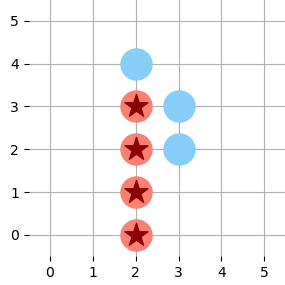

In [44]:
%matplotlib notebook
gameplay=Play(ConnectN(**game_setting), 
              player2=Challenge_Player_MCTS3, 
              player1=Challenge_Player_MCTS2)